In [1]:
import pandas as pd
from shapely.geometry import Point
import geopandas as gpd
import matplotlib.pyplot as plt
from geopandas.datasets import get_path
import folium
from sklearn.cluster import DBSCAN
from sklearn.impute import KNNImputer

In [2]:
#Cleaning the data
df=pd.read_excel("fatal-police-shootings-data_original.xls")
#To fix the wrong format in the date
df['date'] = pd.to_datetime(df['date'])
df.isnull().sum()

id                            0
name                        454
date                          0
manner_of_death               0
armed                       211
age                         503
gender                       31
race                       1517
city                          0
state                         0
signs_of_mental_illness       0
threat_level                  0
flee                        966
body_camera                   0
longitude                   840
latitude                    840
is_geocoding_exact            0
dtype: int64

In [3]:
df.columns

Index(['id', 'name', 'date', 'manner_of_death', 'armed', 'age', 'gender',
       'race', 'city', 'state', 'signs_of_mental_illness', 'threat_level',
       'flee', 'body_camera', 'longitude', 'latitude', 'is_geocoding_exact'],
      dtype='object')

In [4]:
#handling age column using KNN imputation
columns_to_impute = ['age']
# Initialize KNNImputer
imputer = KNNImputer(n_neighbors=5)
# Perform imputation on the 'age' column
df[columns_to_impute] = imputer.fit_transform(df[columns_to_impute])
df.head(5)

,id,name,date,manner_of_death,armed,age,gender,race,city,state,signs_of_mental_illness,threat_level,flee,body_camera,longitude,latitude,is_geocoding_exact
0,3,Tim Elliot,2015-01-02,shot,gun,53.0,M,A,Shelton,WA,True,attack,Not fleeing,False,-123.122,47.247,True
1,4,Lewis Lee Lembke,2015-01-02,shot,gun,47.0,M,W,Aloha,OR,False,attack,Not fleeing,False,-122.892,45.487,True
2,5,John Paul Quintero,2015-01-03,shot and Tasered,unarmed,23.0,M,H,Wichita,KS,False,other,Not fleeing,False,-97.281,37.695,True
3,8,Matthew Hoffman,2015-01-04,shot,toy weapon,32.0,M,W,San Francisco,CA,True,attack,Not fleeing,False,-122.422,37.763,True
4,9,Michael Rodriguez,2015-01-04,shot,nail gun,39.0,M,H,Evans,CO,False,attack,Not fleeing,False,-104.692,40.384,True


In [5]:
print(df.isnull().sum())

id                            0
name                        454
date                          0
manner_of_death               0
armed                       211
age                           0
gender                       31
race                       1517
city                          0
state                         0
signs_of_mental_illness       0
threat_level                  0
flee                        966
body_camera                   0
longitude                   840
latitude                    840
is_geocoding_exact            0
dtype: int64


In [6]:
# Function to categorize age groups
def categorize_age(age):
    if age <= 12:
        return 'Children'
    elif 13 <= age <= 17:
        return 'Adolescents'
    elif 18 <= age <= 59:
        return 'Adult'
    else:
        return 'Old Age'

# Apply the function to create a new 'age_group' column
df['age_group'] = df['age'].apply(categorize_age)

# Display the DataFrame with the new 'age_group' column
df.head(5)

,id,name,date,manner_of_death,armed,age,gender,race,city,state,signs_of_mental_illness,threat_level,flee,body_camera,longitude,latitude,is_geocoding_exact,age_group
0,3,Tim Elliot,2015-01-02,shot,gun,53.0,M,A,Shelton,WA,True,attack,Not fleeing,False,-123.122,47.247,True,Adult
1,4,Lewis Lee Lembke,2015-01-02,shot,gun,47.0,M,W,Aloha,OR,False,attack,Not fleeing,False,-122.892,45.487,True,Adult
2,5,John Paul Quintero,2015-01-03,shot and Tasered,unarmed,23.0,M,H,Wichita,KS,False,other,Not fleeing,False,-97.281,37.695,True,Adult
3,8,Matthew Hoffman,2015-01-04,shot,toy weapon,32.0,M,W,San Francisco,CA,True,attack,Not fleeing,False,-122.422,37.763,True,Adult
4,9,Michael Rodriguez,2015-01-04,shot,nail gun,39.0,M,H,Evans,CO,False,attack,Not fleeing,False,-104.692,40.384,True,Adult


In [7]:

# Create a dictionary mapping cities to their longitude values
city_to_longitude = df.dropna(subset=['longitude']).drop_duplicates('city').set_index('city')['longitude']

# Use the dictionary to fill missing 'longitude' values
df['longitude'] = df['longitude'].fillna(df['city'].map(city_to_longitude))

# Create a dictionary mapping cities to their longitude values
city_to_longitude = df.dropna(subset=['latitude']).drop_duplicates('city').set_index('city')['latitude']

# Use the dictionary to fill missing 'longitude' values
df['latitude'] = df['latitude'].fillna(df['city'].map(city_to_longitude))

df_cities = pd.read_csv('uscities.csv', encoding='latin-1')
df_cities = df_cities[['city','lat','lng']]
df_cities = df_cities.rename(columns={'lat': 'latitude'})
df_cities = df_cities.rename(columns={'lng': 'longitude'})

# Create a dictionary mapping cities to lists of latitude and longitude values from df1
city_to_data = df_cities.groupby('city')[['latitude', 'longitude']].apply(lambda x: x.values.tolist()).to_dict()

# Fill missing values in df2 using the dictionary, but only if they are None
df['latitude'] = df.apply(lambda row: city_to_data.get(row['city'], [[None, None]])[0][0] if pd.isna(row['latitude']) else row['latitude'], axis=1)
df['longitude'] = df.apply(lambda row: city_to_data.get(row['city'], [[None, None]])[0][1] if pd.isna(row['longitude']) else row['longitude'], axis=1)

# This code will fill missing values in df2, but it won't replace existing values
df.isnull().sum()

id                            0
name                        454
date                          0
manner_of_death               0
armed                       211
age                           0
gender                       31
race                       1517
city                          0
state                         0
signs_of_mental_illness       0
threat_level                  0
flee                        966
body_camera                   0
longitude                    81
latitude                     81
is_geocoding_exact            0
age_group                     0
dtype: int64

In [8]:
df = df.dropna(subset=['latitude'])
df.isnull().sum()

id                            0
name                        448
date                          0
manner_of_death               0
armed                       210
age                           0
gender                       31
race                       1490
city                          0
state                         0
signs_of_mental_illness       0
threat_level                  0
flee                        951
body_camera                   0
longitude                     0
latitude                      0
is_geocoding_exact            0
age_group                     0
dtype: int64

In [9]:
df['armed'].fillna(df['armed'].mode()[0], inplace=True)
df['gender'].fillna(df['gender'].mode()[0], inplace=True)
df['flee'].fillna(df['flee'].mode()[0], inplace=True)

In [10]:
# Calculate the most common race for each city
city_to_mode_race = df.groupby('city')['race'].apply(lambda x: x.mode().iloc[0] if not x.mode().empty else None).to_dict()

# Fill null values in the 'race' column with the most common race for the corresponding city
df['race'] = df.apply(lambda row: city_to_mode_race.get(row['city']) if pd.isna(row['race']) else row['race'], axis=1)

# Calculate the most common race for each city
city_to_mode_race = df.groupby('state')['race'].apply(lambda x: x.mode().iloc[0] if not x.mode().empty else None).to_dict()

# Fill null values in the 'race' column with the most common race for the corresponding city
df['race'] = df.apply(lambda row: city_to_mode_race.get(row['state']) if pd.isna(row['race']) else row['race'], axis=1)

In [11]:
df.to_csv('df_cleaned.csv', index=False)

In [12]:
df_anova=df
df_original=df

In [13]:
df_original.head(5)

,id,name,date,manner_of_death,armed,age,gender,race,city,state,signs_of_mental_illness,threat_level,flee,body_camera,longitude,latitude,is_geocoding_exact,age_group
0,3,Tim Elliot,2015-01-02,shot,gun,53.0,M,A,Shelton,WA,True,attack,Not fleeing,False,-123.122,47.247,True,Adult
1,4,Lewis Lee Lembke,2015-01-02,shot,gun,47.0,M,W,Aloha,OR,False,attack,Not fleeing,False,-122.892,45.487,True,Adult
2,5,John Paul Quintero,2015-01-03,shot and Tasered,unarmed,23.0,M,H,Wichita,KS,False,other,Not fleeing,False,-97.281,37.695,True,Adult
3,8,Matthew Hoffman,2015-01-04,shot,toy weapon,32.0,M,W,San Francisco,CA,True,attack,Not fleeing,False,-122.422,37.763,True,Adult
4,9,Michael Rodriguez,2015-01-04,shot,nail gun,39.0,M,H,Evans,CO,False,attack,Not fleeing,False,-104.692,40.384,True,Adult


In [14]:
df.isnull().sum()

id                           0
name                       448
date                         0
manner_of_death              0
armed                        0
age                          0
gender                       0
race                         0
city                         0
state                        0
signs_of_mental_illness      0
threat_level                 0
flee                         0
body_camera                  0
longitude                    0
latitude                     0
is_geocoding_exact           0
age_group                    0
dtype: int64

In [15]:
df['year']=df['date'].dt.year

In [18]:
import seaborn as sns

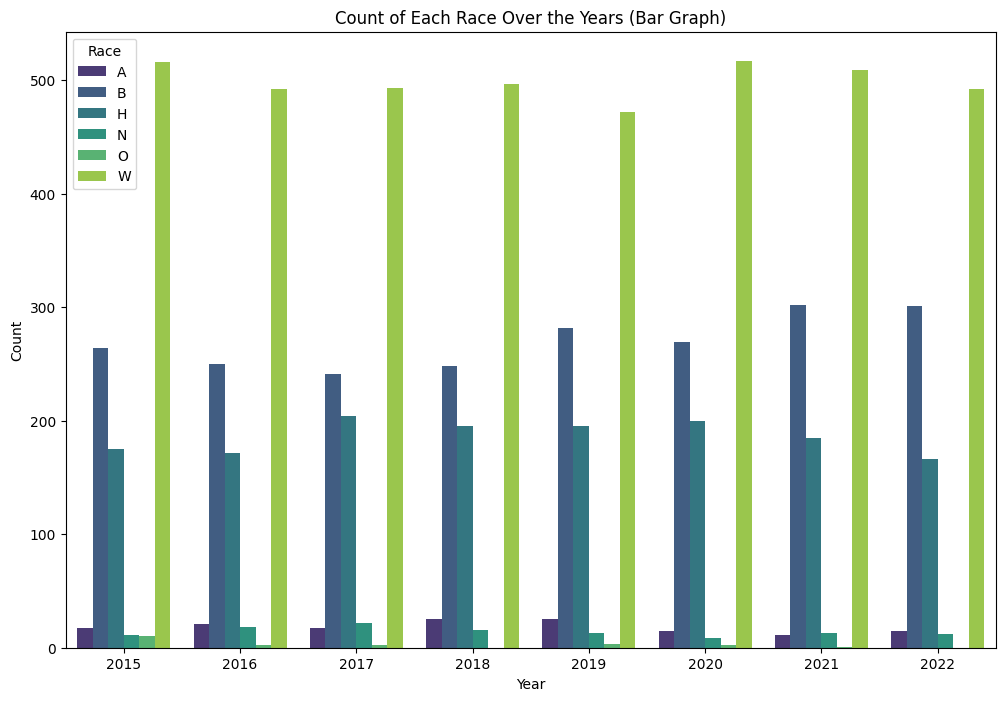

In [19]:
# Group by 'race' and 'year' and count occurrences
grouped_df = df.groupby(['race', 'year']).size().reset_index(name='count')

# Plotting the bar graph
plt.figure(figsize=(12, 8))
sns.barplot(x='year', y='count', hue='race', data=grouped_df, palette='viridis')
plt.title('Count of Each Race Over the Years (Bar Graph)')
plt.xlabel('Year')
plt.ylabel('Count')
plt.legend(title='Race', loc='upper left')
plt.show()

In [20]:

from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
df['encoded_Race'] = label_encoder.fit_transform(df['race'])
df = df.drop('race', axis=1)

In [21]:
df_original.head(5)

,id,name,date,manner_of_death,armed,age,gender,race,city,state,signs_of_mental_illness,threat_level,flee,body_camera,longitude,latitude,is_geocoding_exact,age_group,year,encoded_Race
0,3,Tim Elliot,2015-01-02,shot,gun,53.0,M,A,Shelton,WA,True,attack,Not fleeing,False,-123.122,47.247,True,Adult,2015,0
1,4,Lewis Lee Lembke,2015-01-02,shot,gun,47.0,M,W,Aloha,OR,False,attack,Not fleeing,False,-122.892,45.487,True,Adult,2015,5
2,5,John Paul Quintero,2015-01-03,shot and Tasered,unarmed,23.0,M,H,Wichita,KS,False,other,Not fleeing,False,-97.281,37.695,True,Adult,2015,2
3,8,Matthew Hoffman,2015-01-04,shot,toy weapon,32.0,M,W,San Francisco,CA,True,attack,Not fleeing,False,-122.422,37.763,True,Adult,2015,5
4,9,Michael Rodriguez,2015-01-04,shot,nail gun,39.0,M,H,Evans,CO,False,attack,Not fleeing,False,-104.692,40.384,True,Adult,2015,2


In [22]:
# Run the anova function for all categorical columns
# Defining a function to find the statistical relationship with all the categorical variables
def FunctionAnova(inpData, TargetVariable, CategoricalPredictorList):
    from scipy.stats import f_oneway

    # Creating an empty list of final selected predictors
    SelectedPredictors=[]
    
    print('##### ANOVA Results ##### \n')
    for predictor in CategoricalPredictorList:
        CategoryGroupLists=inpData.groupby(predictor)[TargetVariable].apply(list)
        AnovaResults = f_oneway(*CategoryGroupLists)
        
        # If the ANOVA P-Value is <0.05, that means we reject H0
        if (AnovaResults[1] < 0.05):
            print(predictor, 'is correlated with', TargetVariable, '| P-Value:', AnovaResults[1])
            SelectedPredictors.append(predictor)
        else:
            print(predictor, 'is NOT correlated with', TargetVariable, '| P-Value:', AnovaResults[1])
    
    return(SelectedPredictors)

In [23]:
# Calling the function to check which categorical variables are correlated with target
CategoricalPredictorList=['longitude', 'latitude', 'age']
FunctionAnova(inpData=df_anova, TargetVariable='encoded_Race', CategoricalPredictorList=CategoricalPredictorList)

##### ANOVA Results ##### 

longitude is correlated with encoded_Race | P-Value: 1.3000106498303888e-22
latitude is correlated with encoded_Race | P-Value: 2.1464370891759254e-20
age is correlated with encoded_Race | P-Value: 2.7161890567760563e-60


['longitude', 'latitude', 'age']

In [24]:
def chisq(data,predictors,target):
    from scipy.stats import chi2_contingency
    for p in predictors:
         CrossTabResult=pd.crosstab(index=data[p], columns=data[target])
         ChiSqResult = chi2_contingency(CrossTabResult)
         print('The P-Value of the ChiSq Test with '+p+' is:', ChiSqResult[1])


chisq(df,['id', 'manner_of_death', 'armed', 'gender', 'city', 'state', 'signs_of_mental_illness', 'threat_level',
       'flee', 'body_camera', 'is_geocoding_exact',
       'age_group'],'encoded_Race')


The P-Value of the ChiSq Test with id is: 0.49196586971810574
The P-Value of the ChiSq Test with manner_of_death is: 0.14469529548927104
The P-Value of the ChiSq Test with armed is: 8.494907970430935e-08
The P-Value of the ChiSq Test with gender is: 0.0005358686513742049
The P-Value of the ChiSq Test with city is: 6.4249835449029695e-127
The P-Value of the ChiSq Test with state is: 0.0
The P-Value of the ChiSq Test with signs_of_mental_illness is: 1.1885669159426051e-26
The P-Value of the ChiSq Test with threat_level is: 8.785046414960335e-08
The P-Value of the ChiSq Test with flee is: 4.100252558936795e-16
The P-Value of the ChiSq Test with body_camera is: 9.300936228851596e-19
The P-Value of the ChiSq Test with is_geocoding_exact is: 0.7293726866201282
The P-Value of the ChiSq Test with age_group is: 8.727229255816087e-15


In [25]:
df.columns

Index(['id', 'name', 'date', 'manner_of_death', 'armed', 'age', 'gender',
       'city', 'state', 'signs_of_mental_illness', 'threat_level', 'flee',
       'body_camera', 'longitude', 'latitude', 'is_geocoding_exact',
       'age_group', 'year', 'encoded_Race'],
      dtype='object')

In [26]:
BadColumns=['id', 'name', 'manner_of_death', 'date', 'gender','is_geocoding_exact','state','age']
# Drop bad columns from the data
df.drop(BadColumns, axis=1, inplace=True)
df.head(5)

,armed,city,signs_of_mental_illness,threat_level,flee,body_camera,longitude,latitude,age_group,year,encoded_Race
0,gun,Shelton,True,attack,Not fleeing,False,-123.122,47.247,Adult,2015,0
1,gun,Aloha,False,attack,Not fleeing,False,-122.892,45.487,Adult,2015,5
2,unarmed,Wichita,False,other,Not fleeing,False,-97.281,37.695,Adult,2015,2
3,toy weapon,San Francisco,True,attack,Not fleeing,False,-122.422,37.763,Adult,2015,5
4,nail gun,Evans,False,attack,Not fleeing,False,-104.692,40.384,Adult,2015,2


In [27]:
dummy_df = pd.get_dummies(df['armed'], prefix='armed')
df = pd.concat([df, dummy_df], axis=1)
df = df.drop('armed', axis=1)

dummy_df = pd.get_dummies(df['city'], prefix='city')
df = pd.concat([df, dummy_df], axis=1)
df = df.drop('city', axis=1)

dummy_df = pd.get_dummies(df['signs_of_mental_illness'], prefix='signs_of_mental_illness')
df = pd.concat([df, dummy_df], axis=1)
df = df.drop('signs_of_mental_illness', axis=1)

dummy_df = pd.get_dummies(df['threat_level'], prefix='threat_level')
df = pd.concat([df, dummy_df], axis=1)
df = df.drop('threat_level', axis=1)

dummy_df = pd.get_dummies(df['flee'], prefix='flee')
df = pd.concat([df, dummy_df], axis=1)
df = df.drop('flee', axis=1)

dummy_df = pd.get_dummies(df['body_camera'], prefix='body_camera')
df = pd.concat([df, dummy_df], axis=1)
df = df.drop('body_camera', axis=1)

df['age_group'].replace({'Children':0,'Adolescents':1,'Old Age':2,'Adult':3}, inplace=True)



In [28]:
#Cleaning the data
df_tree=pd.read_csv("df_cleaned.csv")

df_tree.columns

Index(['id', 'name', 'date', 'manner_of_death', 'armed', 'age', 'gender',
       'race', 'city', 'state', 'signs_of_mental_illness', 'threat_level',
       'flee', 'body_camera', 'longitude', 'latitude', 'is_geocoding_exact',
       'age_group'],
      dtype='object')

In [29]:
df_tree.drop(['id','name','date','manner_of_death','city','state','is_geocoding_exact'], axis=1, inplace=True)

In [30]:
df_tree.head(5)


dummy_df = pd.get_dummies(df_tree['armed'], prefix='armed')
df_tree = pd.concat([df_tree, dummy_df], axis=1)
df_tree = df_tree.drop('armed', axis=1)

dummy_df = pd.get_dummies(df_tree['gender'], prefix='gender')
df_tree = pd.concat([df_tree, dummy_df], axis=1)
df_tree = df_tree.drop('gender', axis=1)

dummy_df = pd.get_dummies(df_tree['signs_of_mental_illness'], prefix='signs_of_mental_illness')
df_tree = pd.concat([df_tree, dummy_df], axis=1)
df_tree = df_tree.drop('signs_of_mental_illness', axis=1)

dummy_df = pd.get_dummies(df_tree['threat_level'], prefix='threat_level')
df_tree = pd.concat([df_tree, dummy_df], axis=1)
df_tree = df_tree.drop('threat_level', axis=1)

dummy_df = pd.get_dummies(df_tree['flee'], prefix='flee')
df_tree = pd.concat([df_tree, dummy_df], axis=1)
df_tree = df_tree.drop('flee', axis=1)

dummy_df = pd.get_dummies(df_tree['body_camera'], prefix='body_camera')
df_tree = pd.concat([df_tree, dummy_df], axis=1)
df_tree = df_tree.drop('body_camera', axis=1)

df_tree['age_group'].replace({'Children':0,'Adolescents':1,'Old Age':2,'Adult':3}, inplace=True)

from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
df_tree['encoded_Race'] = label_encoder.fit_transform(df_tree['race'])
df_tree = df_tree.drop('race', axis=1)

In [31]:
df_tree.head(5)

,age,longitude,latitude,age_group,armed_Airsoft pistol,armed_BB gun,armed_BB gun and vehicle,armed_Gun,armed_Taser,armed_air conditioner,...,threat_level_attack,threat_level_other,threat_level_undetermined,flee_Car,flee_Foot,flee_Not fleeing,flee_Other,body_camera_False,body_camera_True,encoded_Race
0,53.0,-123.122,47.247,3,False,False,False,False,False,False,...,True,False,False,False,False,True,False,True,False,0
1,47.0,-122.892,45.487,3,False,False,False,False,False,False,...,True,False,False,False,False,True,False,True,False,5
2,23.0,-97.281,37.695,3,False,False,False,False,False,False,...,False,True,False,False,False,True,False,True,False,2
3,32.0,-122.422,37.763,3,False,False,False,False,False,False,...,True,False,False,False,False,True,False,True,False,5
4,39.0,-104.692,40.384,3,False,False,False,False,False,False,...,True,False,False,False,False,True,False,True,False,2


In [32]:
 #Separate Target Variable and Predictor Variables
TargetVariable='encoded_Race'
Predictors=df_tree.columns[:-1].tolist()
X=df_tree[Predictors].values
y=df_tree[TargetVariable].values

# Split the data into training and testing set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=23)

DecisionTreeClassifier(criterion='entropy', max_depth=3)
              precision    recall  f1-score   support

           0       0.50      0.07      0.12        30
           1       0.43      0.07      0.12       410
           2       0.51      0.70      0.59       315
           3       0.00      0.00      0.00        19
           4       0.00      0.00      0.00         4
           5       0.58      0.78      0.67       806

    accuracy                           0.56      1584
   macro avg       0.34      0.27      0.25      1584
weighted avg       0.52      0.56      0.49      1584

[[  2   0  12   0   0  16]
 [  0  29  49   0   0 332]
 [  1  10 220   0   0  84]
 [  0   0   4   0   0  15]
 [  0   0   2   0   0   2]
 [  1  28 148   0   0 629]]


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

,age,longitude,latitude,age_group,armed_Airsoft pistol,armed_BB gun,armed_BB gun and vehicle,armed_Gun,armed_Taser,armed_air conditioner,...,threat_level_other,threat_level_undetermined,flee_Car,flee_Foot,flee_Not fleeing,flee_Other,body_camera_False,body_camera_True,TargetColumn,Prediction
0,35.0,-82.411,34.87,3,False,False,False,False,False,False,...,True,False,False,False,True,False,False,True,1,5
1,21.0,-90.982,39.067,3,False,False,False,False,False,False,...,False,False,True,False,False,False,True,False,5,5
2,19.0,-102.033,32.011,3,False,False,False,False,False,False,...,True,False,False,False,True,False,True,False,3,2
3,48.0,-122.823,47.036,3,False,False,False,False,False,False,...,True,False,False,False,True,False,True,False,5,5
4,23.0,-81.531,29.448,3,False,False,False,False,False,False,...,True,False,False,False,True,False,True,False,1,1


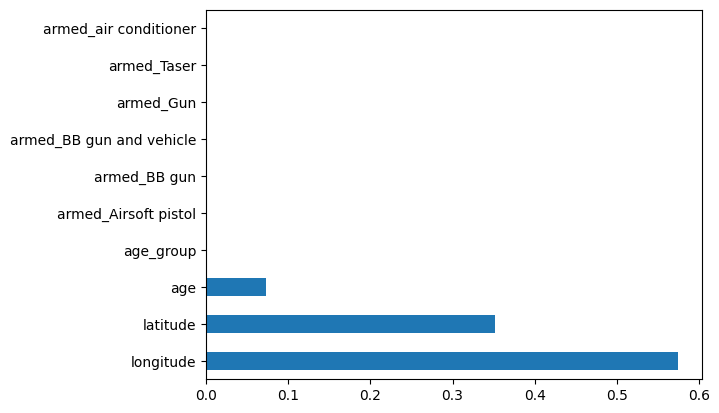

In [33]:
# Story 1 : Given details of a person, determine the race of a particular person?

import pandas as pd
from sklearn import tree
 
#choose from different tunable hyper parameters
clf = tree.DecisionTreeClassifier(max_depth=3,criterion='entropy')
 
#Printing all the parameters of Decision Trees
print(clf)
 
#Creating the model on Training Data
DTree=clf.fit(X_train,y_train)
prediction=DTree.predict(X_test)
 
#Measuring accuracy on Testing Data
from sklearn import metrics
print(metrics.classification_report(y_test, prediction))
print(metrics.confusion_matrix(y_test, prediction))
 
#Plotting the feature importance for Top 10 most important columns
%matplotlib inline
feature_importances = pd.Series(DTree.feature_importances_, index=Predictors)
feature_importances.nlargest(10).plot(kind='barh')
 
#Printing some sample values of prediction
TestingDataResults=pd.DataFrame(data=X_test, columns=Predictors)
TestingDataResults['TargetColumn']=y_test
TestingDataResults['Prediction']=prediction
TestingDataResults.head()

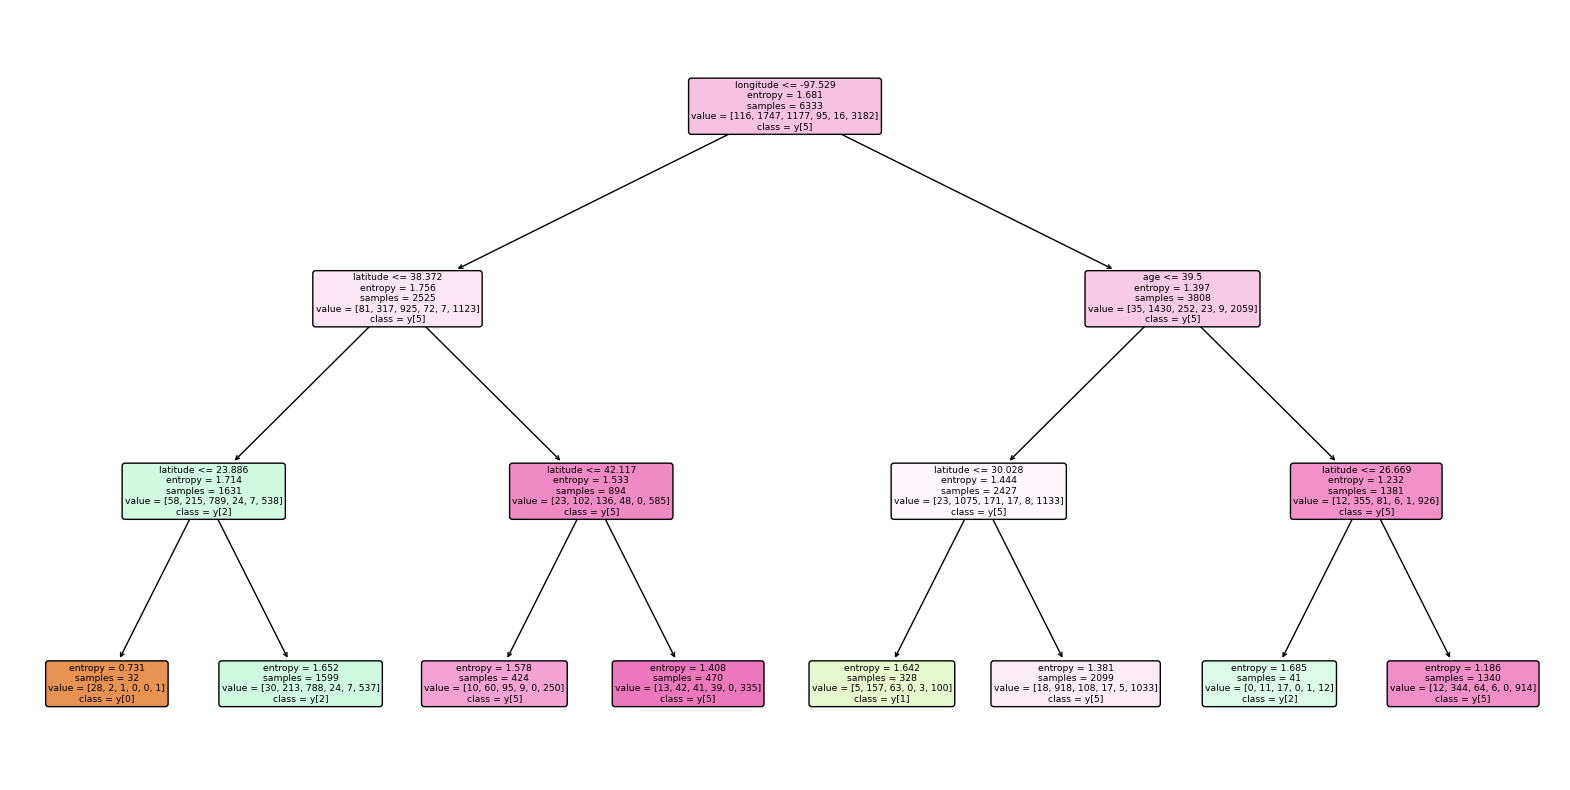

In [34]:
# Plotting the decision tree
plt.figure(figsize=(20, 10))
tree.plot_tree(DTree, filled=True, feature_names=Predictors, class_names=True, rounded=True)
plt.show()

In [35]:
df_cal=df_original[df_original['state']=='CA']

In [36]:
# Generate random latitude and longitude data
import numpy as np
np.random.seed(42)
latitude = df_cal['latitude'].values
longitude = df_cal['longitude'].values
X = np.column_stack((latitude, longitude))

# Create a DataFrame to represent the data with labels
ClusterData = pd.DataFrame(X, columns=['Latitude', 'Longitude'])
print(ClusterData.head())

# Create dendrogram to find the best number of clusters
dendrogram = sch.dendrogram(sch.linkage(X, method='ward'))

# Creating 2 clusters based on the dendrogram
hc = AgglomerativeClustering(n_clusters=6, affinity='euclidean', linkage='ward')

# Generating cluster id for each row using agglomerative algorithm
ClusterData['PredictedClusterID'] = hc.fit_predict(X)
print(ClusterData.head())

# Create a map centered on the average coordinates
map_center = [np.mean(latitude), np.mean(longitude)]
mymap = folium.Map(location=map_center, zoom_start=5)

# Define a color palette for the clusters
colors = ['pink', 'yellow','green','purple','red','blue']

# Add markers for each point with different colors based on the cluster
for lat, lon, cluster in zip(latitude, longitude, ClusterData['PredictedClusterID']):
    color = colors[cluster]
    folium.CircleMarker(location=[lat, lon], radius=5, color=color, fill=True, fill_color=color).add_to(mymap)

# Save the map to an HTML file or display it
#mymap.save('map_with_hierarchical_clusters.html')
# OR
mymap

   Latitude  Longitude
0    37.763   -122.422
1    37.930   -121.299
2    33.951   -118.183
3    38.266   -121.997
4    37.588   -122.060


NameError: name 'sch' is not defined

In [37]:
df_cal['PredictedClusterID'] = ClusterData['PredictedClusterID']

KeyError: 'PredictedClusterID'

   Latitude  Longitude
0    37.763   -122.422
1    37.930   -121.299
2    33.951   -118.183
3    38.266   -121.997
4    37.588   -122.060
   Latitude  Longitude  PredictedClusterID
0    37.763   -122.422                   1
1    37.930   -121.299                   1
2    33.951   -118.183                   2
3    38.266   -121.997                   1
4    37.588   -122.060                   1


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/var/folders/6s/29p4p7rs2c74f5xgjj96pn880000gn/T/ipykernel_954/183680354.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cal['PredictedClusterID'] = ClusterData['PredictedClusterID']


TypeError: list indices must be integers or slices, not float

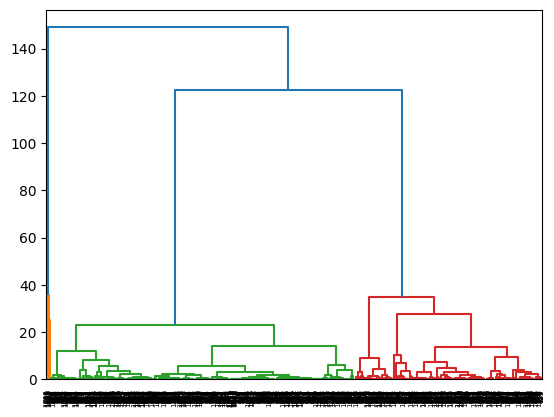

In [38]:
import numpy as np
import pandas as pd
import folium
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering

# Assuming you already have df_cal with 'latitude' and 'longitude' columns

# Generate random latitude and longitude data
np.random.seed(42)
latitude = df_cal['latitude'].values
longitude = df_cal['longitude'].values
X = np.column_stack((latitude, longitude))

# Create a DataFrame to represent the data with labels
ClusterData = pd.DataFrame(X, columns=['Latitude', 'Longitude'])
print(ClusterData.head())

# Create dendrogram to find the best number of clusters
dendrogram = sch.dendrogram(sch.linkage(X, method='ward'))

# Creating 6 clusters based on the dendrogram
hc = AgglomerativeClustering(n_clusters=6, affinity='euclidean', linkage='ward')

# Generating cluster id for each row using the agglomerative algorithm
ClusterData['PredictedClusterID'] = hc.fit_predict(X)
print(ClusterData.head())

# Add cluster ID to df_cal
df_cal['PredictedClusterID'] = ClusterData['PredictedClusterID']

# Create a map centered on the average coordinates
map_center = [np.mean(latitude), np.mean(longitude)]
mymap = folium.Map(location=map_center, zoom_start=5)

# Define a color palette for the clusters
colors = ['pink', 'yellow', 'green', 'purple', 'red', 'blue']

# Add markers for each point with different colors based on the cluster
for lat, lon, cluster in zip(df_cal['latitude'], df_cal['longitude'], df_cal['PredictedClusterID']):
    color = colors[cluster]
    folium.CircleMarker(location=[lat, lon], radius=5, color=color, fill=True, fill_color=color).add_to(mymap)

# Save the map to an HTML file or display it
# mymap.save('map_with_hierarchical_clusters.html')
# OR
mymap


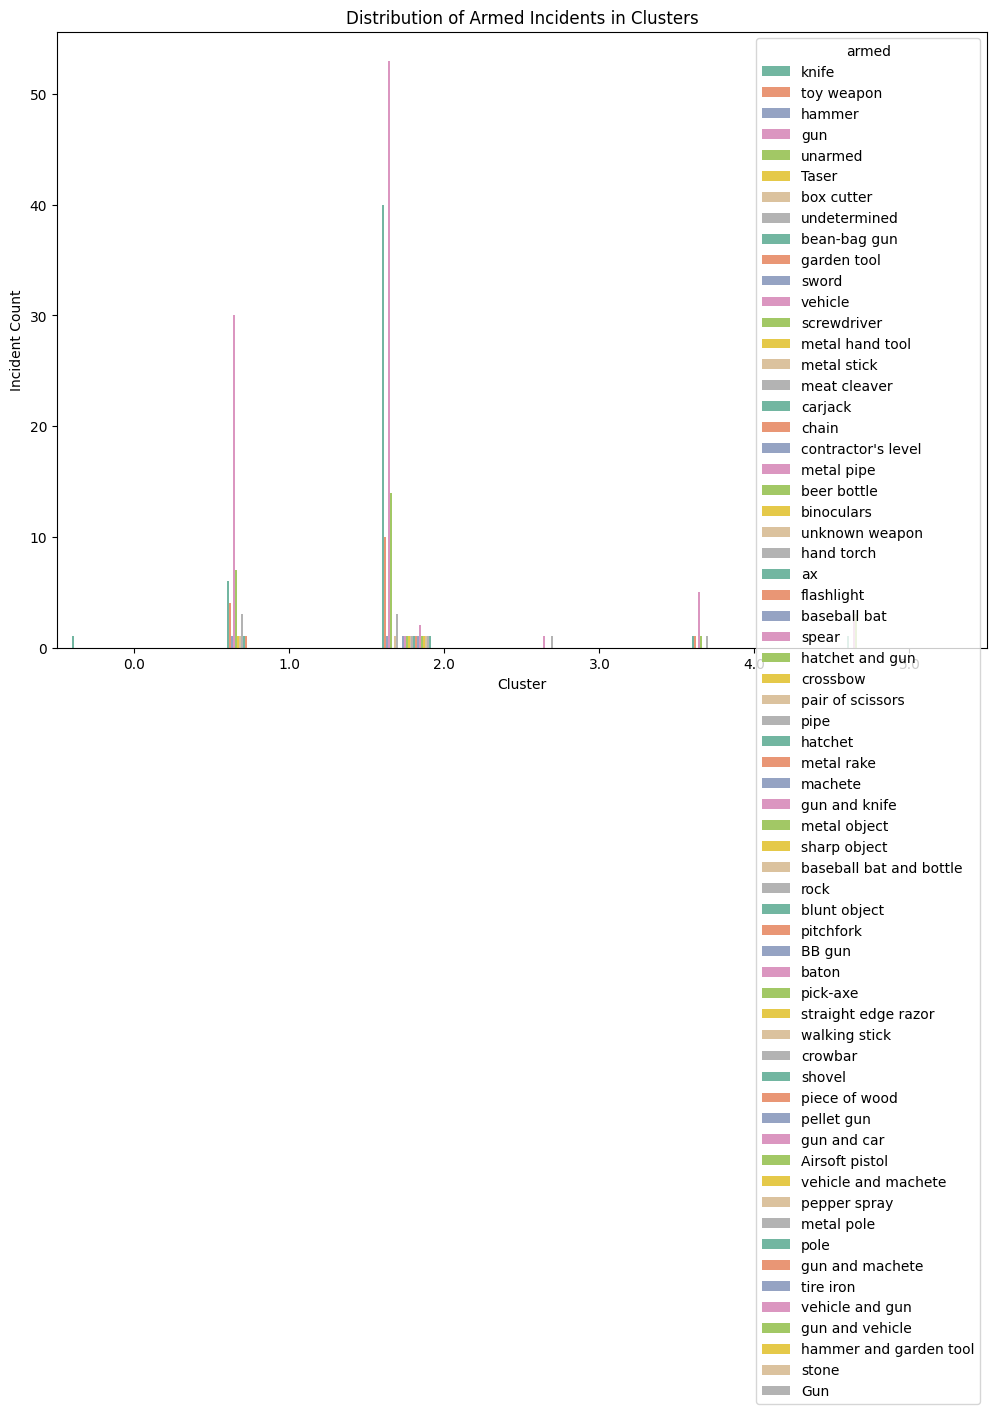

In [ ]:
#1) Spatial Distribution of Clusters:
import seaborn as sns
plt.figure(figsize=(12, 8))
sns.countplot(x='PredictedClusterID', hue='armed', data=df_cal, palette='Set2')
plt.title('Distribution of Armed Incidents in Clusters')
plt.xlabel('Cluster')
plt.ylabel('Incident Count')
plt.show()

In [ ]:
df_cal.columns

Index(['id', 'name', 'date', 'manner_of_death', 'armed', 'age', 'gender',
       'race', 'city', 'state', 'signs_of_mental_illness', 'threat_level',
       'flee', 'body_camera', 'longitude', 'latitude', 'is_geocoding_exact',
       'age_group', 'encoded_Race', 'PredictedClusterID'],
      dtype='object')

In [ ]:
# Demographic Analysis within Clusters:
# Are there demographic differences in the clusters?
# Assuming you have demographic information in columns like 'age', 'gender', 'race'

  
cluster_demographics = df_cal.groupby(['PredictedClusterID','manner_of_death', 'armed', 'age', 'gender',
       'race', 'signs_of_mental_illness', 'threat_level',
       'flee', 'body_camera',
       'age_group']).size().reset_index(name='Count')

KeyError: 'PredictedClusterID'

In [ ]:
#1)age 
cluster_stats_age = df_cal.groupby('PredictedClusterID')[['age']].mean()
cluster_stats_age

,age
PredictedClusterID,
0.0,39.000000
1.0,33.745455
2.0,35.597140
3.0,25.000000
4.0,32.666667
5.0,34.000000


In [ ]:
#1)age_group
cluster_stats_age_gp= df_cal.groupby('PredictedClusterID')[['age_group']].apply(lambda x: x.mode().iloc[0])
cluster_stats_age_gp

,age_group
PredictedClusterID,
0.0,Adult
1.0,Adult
2.0,Adult
3.0,Adolescents
4.0,Adult
5.0,Adult


In [ ]:
#threat_level
cluster_stats_threat_level= df_cal.groupby('PredictedClusterID')[['threat_level']].apply(lambda x: x.mode().iloc[0])
cluster_stats_threat_level

,threat_level
PredictedClusterID,
0.0,other
1.0,attack
2.0,attack
3.0,attack
4.0,attack
5.0,attack


In [ ]:
#armed
cluster_stats_armed= df_cal.groupby('PredictedClusterID')[['armed']].apply(lambda x: x.mode().iloc[0])
cluster_stats_armed

,armed
PredictedClusterID,
0.0,knife
1.0,gun
2.0,gun
3.0,gun
4.0,gun
5.0,gun


In [ ]:
#flee
cluster_stats_flee= df_cal.groupby('PredictedClusterID')[['flee']].apply(lambda x: x.mode().iloc[0])
cluster_stats_flee

,flee
PredictedClusterID,
0.0,Not fleeing
1.0,Not fleeing
2.0,Not fleeing
3.0,Car
4.0,Not fleeing
5.0,Not fleeing


In [ ]:
# Incident Characteristics within Clusters:
# What are the common characteristics (manner_of_death, armed, etc.) within each cluster?
# Assuming you have incident information in columns like 'manner_of_death', 'armed', etc.
cluster_incident_info = df_cal.groupby(['PredictedClusterID', 'flee', 'armed', 'threat_level','age_group']).size().reset_index(name='Count')
cluster_incident_info.sort_values(by='Count', ascending=False)


,PredictedClusterID,flee,armed,threat_level,age_group,Count
45,2.0,Not fleeing,gun,attack,Adult,24
50,2.0,Not fleeing,knife,other,Adult,23
8,1.0,Not fleeing,gun,attack,Adult,19
49,2.0,Not fleeing,knife,attack,Adult,13
21,2.0,Car,gun,attack,Adult,13
...,...,...,...,...,...,...
38,2.0,Not fleeing,beer bottle,undetermined,Adult,1
40,2.0,Not fleeing,box cutter,other,Adult,1
41,2.0,Not fleeing,carjack,other,Adult,1
42,2.0,Not fleeing,chain,attack,Adult,1


In [ ]:
# Assuming cluster_incident_info is your DataFrame

# Find the index of the row with the maximum count for each cluster
max_count_index = cluster_incident_info.groupby('PredictedClusterID')['Count'].idxmax()

# Use loc to retrieve the corresponding rows
max_count_rows = cluster_incident_info.loc[max_count_index]

# Print the result
max_count_rows


,PredictedClusterID,flee,armed,threat_level,age_group,Count
0,0.0,Not fleeing,knife,other,Adult,1
8,1.0,Not fleeing,gun,attack,Adult,19
45,2.0,Not fleeing,gun,attack,Adult,24
65,3.0,Car,gun,attack,Adolescents,1
69,4.0,Not fleeing,gun,attack,Adult,3
74,5.0,Foot,unarmed,other,Adult,2


In [ ]:
df['race'].unique()

array(['A', 'W', 'H', 'B', 'O', nan, 'N'], dtype=object)

In [ ]:
#Cleaning the data
df=pd.read_excel("fatal-police-shootings-data_original.xls")

df_cal=df[df['state']=='CA']

# Prior probability of being shot (replace with your actual prior knowledge or estimate)
prior_prob_shot = df_cal[df_cal['manner_of_death'] == 'shot and Tasered'].shape[0] / df_cal.shape[0]

# Prior probability of being male (replace with your actual prior knowledge or estimate)
prior_prob_male = df_cal[df_cal['gender'] == 'M'].shape[0] / df_cal.shape[0]

# Prior probability of being Black (replace with your actual prior knowledge or estimate)
prior_prob_black = df_cal[df_cal['race'] == 'A'].shape[0] / df_cal.shape[0]

# Likelihood of being shot given that the person is male and Black
likelihood_shot_given_male_and_black = df_cal[(df_cal['gender'] == 'M') & (df_cal['race'] == 'A') & (df_cal['manner_of_death'] == 'shot and Tasered')].shape[0] / df_cal[(df_cal['gender'] == 'M') & (df_cal['race'] == 'A')].shape[0]

# Apply Bayes' theorem
posterior_prob_male_shot_given_black = (likelihood_shot_given_male_and_black * prior_prob_shot) / prior_prob_black

print(f"The posterior probability of a Male being shot when the person is from the Asian race is approximately: {posterior_prob_male_shot_given_black:.4f}")

The posterior probability of a Male being shot when the person is from the Asian race is approximately: 0.1032


In [ ]:
#Cleaning the data
df=pd.read_excel("fatal-police-shootings-data_original.xls")

df_cal=df[df['state']=='CA']

# Prior probability of being shot (replace with your actual prior knowledge or estimate)
prior_prob_shot = df_cal[df_cal['manner_of_death'] == 'shot and Tasered'].shape[0] / df_cal.shape[0]

# Prior probability of being male (replace with your actual prior knowledge or estimate)
prior_prob_male = df_cal[df_cal['gender'] == 'M'].shape[0] / df_cal.shape[0]

# Prior probability of being Black (replace with your actual prior knowledge or estimate)
prior_prob_black = df_cal[df_cal['race'] == 'W'].shape[0] / df_cal.shape[0]

# Likelihood of being shot given that the person is male and Black
likelihood_shot_given_male_and_black = df_cal[(df_cal['gender'] == 'M') & (df_cal['race'] == 'W') & (df_cal['manner_of_death'] == 'shot and Tasered')].shape[0] / df_cal[(df_cal['gender'] == 'M') & (df_cal['race'] == 'W')].shape[0]

# Apply Bayes' theorem
posterior_prob_male_shot_given_black = (likelihood_shot_given_male_and_black * prior_prob_shot) / prior_prob_black

print(f"The posterior probability of a Male being shot when the person is from the White race is approximately: {posterior_prob_male_shot_given_black:.4f}")

The posterior probability of a Male being shot when the person is from the White race is approximately: 0.0177


In [ ]:
#Cleaning the data
df=pd.read_excel("fatal-police-shootings-data_original.xls")

df_cal=df[df['state']=='CA']

# Prior probability of being shot (replace with your actual prior knowledge or estimate)
prior_prob_shot = df_cal[df_cal['manner_of_death'] == 'shot and Tasered'].shape[0] / df_cal.shape[0]

# Prior probability of being male (replace with your actual prior knowledge or estimate)
prior_prob_male = df_cal[df_cal['gender'] == 'M'].shape[0] / df_cal.shape[0]

# Prior probability of being Black (replace with your actual prior knowledge or estimate)
prior_prob_black = df_cal[df_cal['race'] == 'B'].shape[0] / df_cal.shape[0]

# Likelihood of being shot given that the person is male and Black
likelihood_shot_given_male_and_black = df_cal[(df_cal['gender'] == 'M') & (df_cal['race'] == 'B') & (df_cal['manner_of_death'] == 'shot and Tasered')].shape[0] / df_cal[(df_cal['gender'] == 'M') & (df_cal['race'] == 'B')].shape[0]

# Apply Bayes' theorem
posterior_prob_male_shot_given_black = (likelihood_shot_given_male_and_black * prior_prob_shot) / prior_prob_black

print(f"The posterior probability of a Male being shot when the person is from the Black race is approximately: {posterior_prob_male_shot_given_black:.4f}")

The posterior probability of a Male being shot when the person is from the Black race is approximately: 0.0166


In [ ]:
#Cleaning the data
df=pd.read_excel("fatal-police-shootings-data_original.xls")

df_cal=df[df['state']=='CA']

# Prior probability of being shot (replace with your actual prior knowledge or estimate)
prior_prob_shot = df_cal[df_cal['manner_of_death'] == 'shot and Tasered'].shape[0] / df_cal.shape[0]

# Prior probability of being male (replace with your actual prior knowledge or estimate)
prior_prob_male = df_cal[df_cal['gender'] == 'M'].shape[0] / df_cal.shape[0]

# Prior probability of being Black (replace with your actual prior knowledge or estimate)
prior_prob_black = df_cal[df_cal['race'] == 'H'].shape[0] / df_cal.shape[0]

# Likelihood of being shot given that the person is male and Black
likelihood_shot_given_male_and_black = df_cal[(df_cal['gender'] == 'M') & (df_cal['race'] == 'H') & (df_cal['manner_of_death'] == 'shot and Tasered')].shape[0] / df_cal[(df_cal['gender'] == 'M') & (df_cal['race'] == 'H')].shape[0]

# Apply Bayes' theorem
posterior_prob_male_shot_given_black = (likelihood_shot_given_male_and_black * prior_prob_shot) / prior_prob_black

print(f"The posterior probability of a Male being shot when the person is from the 'H' race is approximately: {posterior_prob_male_shot_given_black:.4f}")

The posterior probability of a Male being shot when the person is from the 'H' race is approximately: 0.0089
